# 3.3 미래에 볼 영화의 평점 예측하기

데이터 분석을 통해 아직 사람들이 보지 않았지만 좋아할 만한 영화들을 추천할 수 있을까요? 넷플릭스같은 서비스들은 이러한 것들을 평점 예측 기본으로 제공하고 있습니다. 이번 절에서는 이러한 평점 예측 기법을 알아보겠습니다.

## Step 1 탐색: MovieLens 데이터 살펴보기
MovieLens 데이터는 총 3개의 데이터셋으로 분리되어 있으며 데이터셋을 구성하는 피처는 아래와 같습니다.

- 데이터셋 : 피처
- rating 데이터 : user_id(유저 번호), movie_id(영화 번호), rating(점수), time(데이터 등록시간)
- movie 데이터 : movie_id(영화 번호), title(영화 제목), genre(장르)
- user  데이터 : uesr_id(유저 번호), gender(성별), age(나이), occupation(직업-개인정보1), zipcode(주소 코드-개인정보2)

각 데이터는 '::' 구분자로 열을 구분하였기 때문에 read_csv() 함수를 사용할 때 delimiter='::' 파라미터를 포함해야 합니다. 3개의 데이터(rating_data, movie_data, user_data)를 각각 head() 함수로 살펴본 결과는 다음과 같습니다.

#### MovieLens 데이터셋의 기본 정보 구하기

In [1]:
# -*- coding: uft-8 -*-
%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data source : https://grouplens.org/datasets/movielens

rating_file_path = "data/ml-1m/ratings.dat"
movie_file_path = "data/ml-1m/movies.dat"
user_file_path = "data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path,
                                    names=['user_id', 'movie_id', 'rating', 'time'],
                                    delimiter='::', encoding= 'ISO-8859-1')
movie_data = pd.io.parsers.read_csv(movie_file_path,
                                   names=['movie_id', 'title', 'genre'],
                                   delimiter='::', encoding= 'ISO-8859-1')
user_data = pd.io.parsers.read_csv(user_file_path,
                                  names=['user_id', 'gender', 'age', 'occupation', 'zipcode'],
                                  delimiter='::', encoding= 'ISO-8859-1')

/home/ubuntu/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [2]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Step 2 분석: 탐색적 데이터 분석하기
탐색적 데이터 분석을 통해 영화 데이터를 살펴보자. 다음의 실행 결과는 영화의 개수와 연도별 탐색에 대한 출력 결과이다. 영화의 개수는 약 4,000여 개 정도라는 것을 알 수 있고, 1990년대 후반부터 2000년대 초반의 영화가 가장 많은 것을 알 수 있다. 영화의 연도 정보는 movie_data['title'].apply(lambda x:x[-5:-1]) 코드를 통해 추출한 것으로 영화의 제목 뒤에 따라붙는 연도 정보를 이용한 것이다.

#### 분석할 영화의 정보  탐색하기

In [5]:
# 총 영화의 개수를 출력합니다.
print("total number of movie in data:",len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 top10 연도를 출력합니다.
movie_data['year'] = movie_data['title'].apply(lambda x:x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data: 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

In [23]:
# 연대별 영화의 개수를 출력합니다.
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
moview_year_term = movie_data['year_term'].value_counts().sort_index()
print(moview_year_term)

1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: year_term, dtype: int64


/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


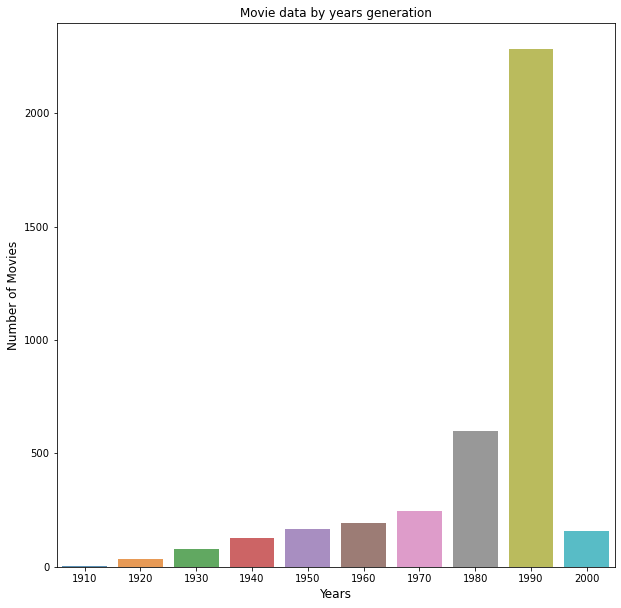

In [24]:
sns.barplot(moview_year_term.index, moview_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

다음으로 영화 데이터에서 가장 많이 등장한 장르가 무엇인지를 탐색해봅시다. movie_data의 피처인 genre는 '드라마 | 코미디 | 액션'처럼'|'이라는 구분자를 포함하여 여러 장르를 하나의 문자열에 포함하고 있습니다. 따라서 데이터에 등장하는 모든 개별 장르를 세기 위해서는 split() 함수로 genre 데이터를 분리해야 합니다. 각 장르마다의 등장 개수는 dictionary 자료로 저장합니다. 실행 코드는 다음과 같습니다.

#### 장르의 속성 탐색하기

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


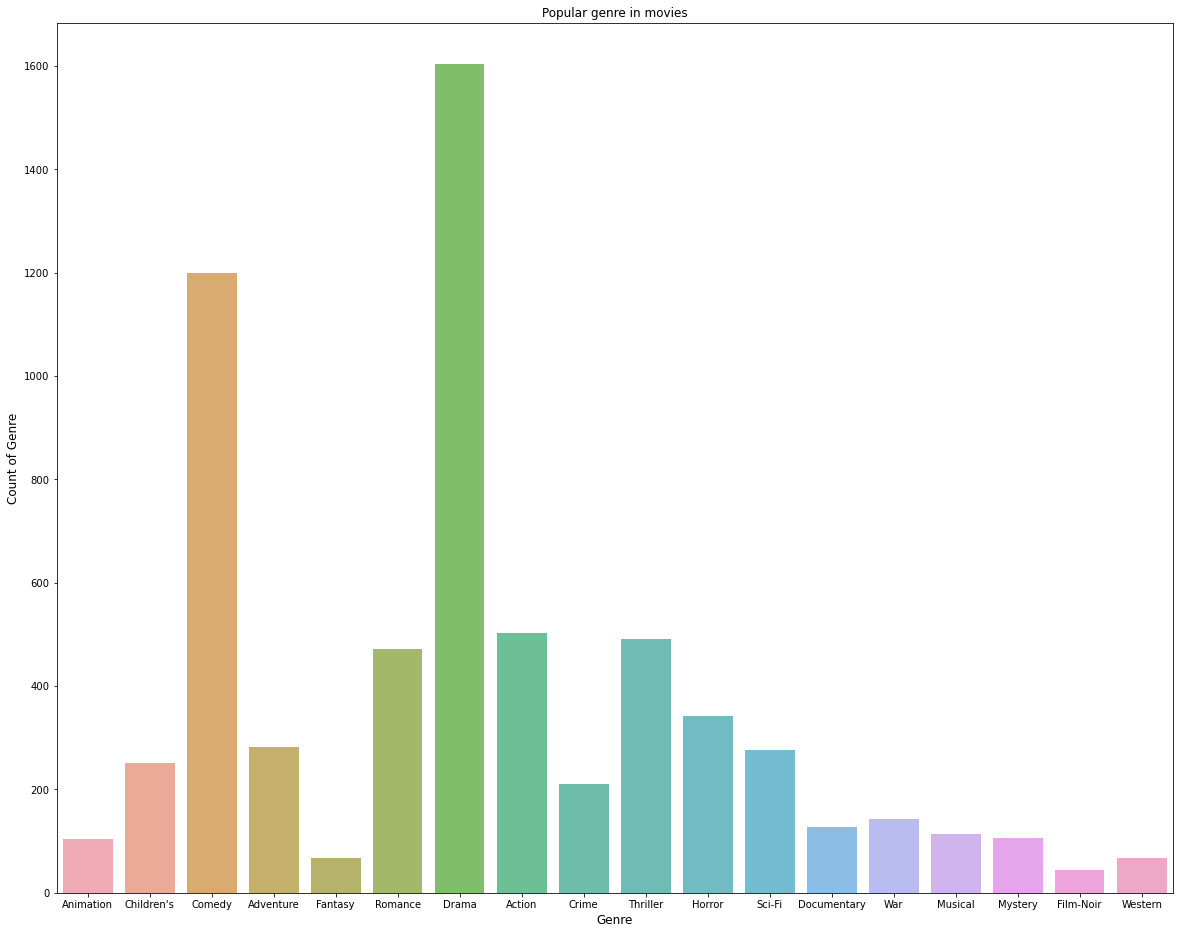

In [9]:
# 가장 많이 등장한 장르의 속성을 추출합니다. (예시: Drama)
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    
    # genre 피처를 '|' 구분자로 분리합니다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장합니다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [20,16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

그리고 분석 대상이 되는 유저의 수를 탐색해보면 총 6,040명으로 나타납니다.

#### 분석할 유저의 정보 탐색하기

In [10]:
# 유저의 수를 탐색합니다.
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


- 유저 데이터에 대한 탐색적 데이터 분석을 실행해 봅시다.
    - 유저의 성별 탐색 
    - 유저의 연령대 탐색

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


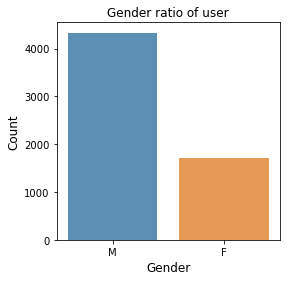

In [25]:
# 유저의 성별을 탐색합니다.
plt.rcParams['figure.figsize'] = [4, 4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [26]:
# 유저의 연령대를 탐색합니다.
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [27]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


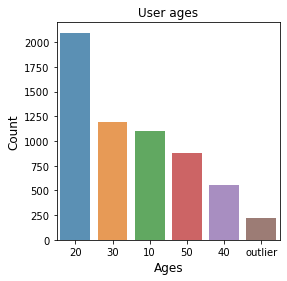

In [28]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

지금까지 user_data, movie_data 데이터의 특징을 살펴본 것은'평점 예측'의 측면에서는 중요한 탐색이라고 볼 수 없었습니다. 하지만 rating 데이터는 평점 예측 데이터 분석에 중요한 데이터이기때문에 조금 더 자세히 탐색을 수행할 필요가 있습니다.<br>
아래의 코드는 각 영화가 얼마나 많은 평가를 받았는지를 탐색합니다. 실행 결과 그래프는'movie_id'를 기준으로 groupby() 한뒤,'rating'에 count() 함수를 적용한 결과입니다. x축은 각 영화가 평가받은 횟수, y축은 각 영화가 평가받은 횟수를 의미합니다. 이를 통해 약 3,800여 개의 영화중 100개 미만의 평가를 받은 영화가 1,700여 개나 된다는 것을 알 수 있습니다. 이러한 영화들을 대상으로 한 '예상 평점'분석은 관람객에게 큰 의미가 있을 것입니다.

#### 평점 데이터의 정보 탐색하기

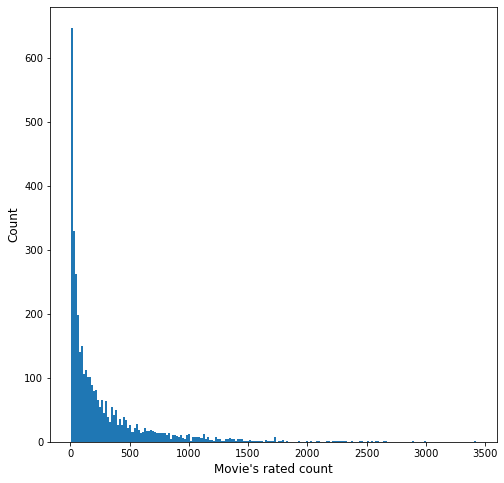

total number of movie in data : 3883
total number of movie rated below 100 : 1687


In [11]:
# 각 영화가 평가받은 횟수를 탐색합니다.
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8,8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

다음은 각 영화의 평균 평점을 알아보겠습니다. 아래의 코드에서는 agg() 함수로 각 영화당 rating의 개수와 평균값을 계산합니다. 평균값에 대한 시각화는 실행 결과와 같습니다. 대부분의 평점은 2점 ~ 4점 사이로 나타났으며, 이를 통해 대부분의 영화 평점은 2점 ~ 4점 사이의 값으로 예측될 것이라는 가설을 수립할 수 있습니다.

In [16]:
# 영화별 평균 평점을 탐색합니다.
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [22]:
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<AxesSubplot:>

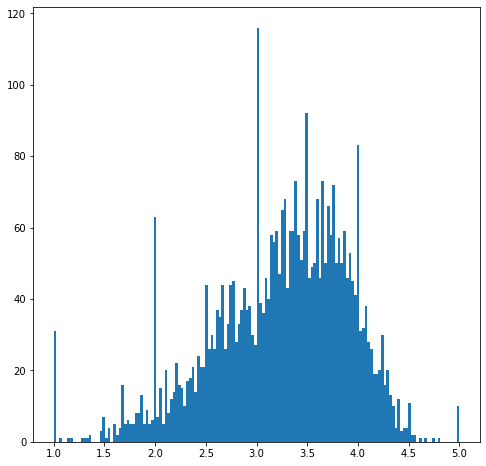

In [18]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

In [19]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력합니다.
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)



- 동일한 방식으로, 유저 그룹 단위의 평점 속성을 분석.
    - 유저별로 평가한 영화 개수
    - 유저별로 평가한 평균 영화 점수
    - 유저별로 평가한 영화 점수의 편차

In [29]:
# 유저별 영화 평가를 탐색합니다.
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg(['count','mean', 'std'])
user_grouped_rating_info.columns = ['rated_count', 'rating_mean', 'rating_std']

In [30]:
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


<AxesSubplot:>

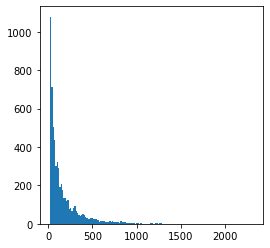

In [31]:
# 유저별로 평가한 영화 개수의 분포를 출력합니다.
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

<AxesSubplot:>

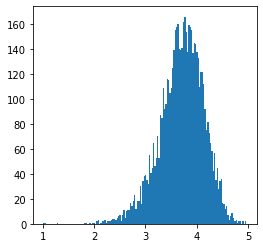

In [32]:
# 유저별로 평가한 영화 점수 평균의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

<AxesSubplot:>

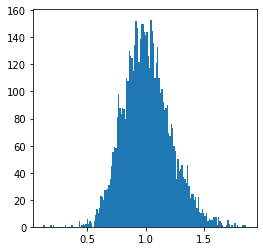

In [33]:
# 유저별로 평가한 영화 점수 편차의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

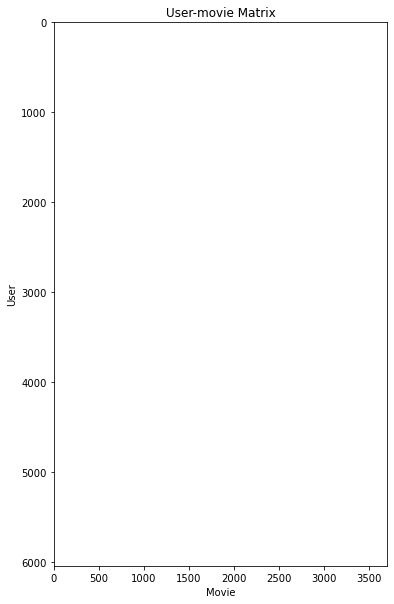

In [21]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성한다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(['user_id','movie_id']).unstack()

# user- movie 표를 시각화 한다
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()